In [1]:
# import PyPDF2
# import spacy
import numpy as np
import pandas as pd
import fitz
import nltk

from nltk.tokenize import sent_tokenize
# from pathlib import Path

import os

# nlp = spacy.load('en_core_web_lg')

In [2]:
# sent_list = []

# for page in pdf_text[2:]:
#     doc = nlp(page)
#     for sentence in doc.sents:
#         sent_list.append(sentence)

In [3]:
path_pdf = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data\\reports'
fname_out = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data_structured\\report_sentences.csv'

In [4]:
def get_cnt(text):
    cnt = 0
    for word in text.split():
        if word.isalnum():
            cnt += 1
    return cnt

In [5]:
def get_text(block_lst):

    MIN_WORD_CNT = 6
    
    text_lst = []
    for block in block_lst:
        if block[6] != 0: continue # block_type: 0 = text
        
        #I'm replacing the non-ascii single quotation mark here, because it's used in Coca Cola's report
        text = block[4].replace('’',"'")
        text = ''.join([i if ord(i) < 128 else ' ' for i in text])
    
        if get_cnt(text) < MIN_WORD_CNT: continue # Delete sentences with less than MIN_WORD_CNT(10) 
    
        text_lst.append(text.replace('-\n', ''))
        #.replace('-\n', '')
    return ('\n'.join(text_lst))

In [6]:
# test_sent = sent_tokenize(text)[2]

# r_sent = ' '.join(test_sent.split()) #split splits the words of the sentence into a list - and gets rid of /n etc.

# ' '.join(test_sent.split()) #joins the items of the list with a space 

In [6]:
def get_sentence(fname):
 
    doc = fitz.open(fname)
    
    sent_lst = []
    for page_no, page in enumerate(doc):
        
        block_lst = page.get_text_blocks()
        text = get_text(block_lst)
    
        for token in sent_tokenize(text):
            sentences = token.split('\n\n')
            for sentence in sentences:
                r_sent = ' '.join(sentence.split()) # Delete '\n', '\t' and strip
                sent_lst.append(r_sent)
            
    doc.close()

    return sent_lst

In [52]:
doc = fitz.open(os.path.join(path_pdf,'boeing.pdf'))

sent_lst = []
for page_no, page in enumerate(doc):

    block_lst = page.get_text_blocks()
    text = get_text(block_lst)

    for token in sent_tokenize(text):
        sentences = token.split('\n\n')
        for sentence in sentences:
            r_sent = ' '.join(sentence.split()) # Delete '\n', '\t' and strip
            sent_lst.append(r_sent)

doc.close()

In [54]:
text

"Championing This Idea:  Commit to \nDo What You Can'\n\nEnvironmental scientist Kristin Marshall is \nBoeing's 2021 Environment Champion, an \nannual award given to an employee who \nexemplifies leadership by improving  \nenvironmental performance and inspiring \nothers to do the same.\n\nThroughout her career, Marshall has been \ninspired by one of President Theodore \nRoosevelt's favorite sayings:  Do what you \ncan, with what you've got, where you are.  \nShe encourages everyone at Boeing to act  \nto ensure environmental sustainability.\n\nSome examples of Marshall's environmental \ncommitment include leading the installation  \nof an award-winning rain garden and working \nwith a team to implement automated \nenvironmental monitoring at paint booths. \n\n Many of the sustainability and environmental \nchallenges we face are definitely huge in \nscale, but everyone at Boeing can   and \nshould   contribute to the solution,  Marshall \nsaid.  You can figure out what single action \

In [7]:
def gen_document(fname, sent_lst):

    res_df = pd.DataFrame(
        {
            'doc_type': 'report',
            'company': fname.split('.')[0],
            'sentence': sent_lst
        }
    )
    
    return res_df

In [8]:
def read_filelist(path):

    # Create empty DataFrame
    df = pd.DataFrame()
    
    # Read file list (directory)
    for idx, fname in enumerate(os.listdir(path)):
        p_fname = os.path.join(path, fname)
        print('path + fname >>>', p_fname)
        
        if p_fname.split('.')[-1] != 'pdf': continue
        print('fname >>>',fname)
    
#         doc_id = int(idx)
        
#         print(f'doc_id = [{doc_id}], fname = [{fname}]')
#         print('')
    
        sent_lst = get_sentence(p_fname)
        df_doc   = gen_document(fname, sent_lst)
        
        df = pd.concat([df,df_doc])
        
    return df

In [15]:
%%time
df = read_filelist(path_pdf)
print('==== End of jobs ====')

path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\abb.pdf
fname >>> abb.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\adidas.pdf
fname >>> adidas.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\airbus.pdf
fname >>> airbus.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\apple.pdf
fname >>> apple.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\bayer.pdf
fname >>> bayer.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\beiersdorf.pdf
fname >>> beiersdorf.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\blackrock.pdf
fname >>> blackrock.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\D

In [72]:
df.isnull().sum()

doc_type      0
company       0
sentence      0
word count    0
dtype: int64

In [33]:
df.drop_duplicates(subset = ['sentence'], inplace = True)

In [34]:
df.shape

(45892, 3)

In [49]:
df['sentence'].values[6001]

"In this year's report, we have included our contribution to Ipieca's SDG Roadmap for the oil and gas sector."

In [51]:
df[df['company']=='mondelez']

,doc_type,company,sentence
0,report,mondelez,Governance Sustainable Snacking Colleague & Co...
1,report,mondelez,2 MONDEL Z INTERNATIONAL SNACKING MADE RIGHT 2...
2,report,mondelez,From Cadbury Dairy Milk chocolate to Triscuit ...
3,report,mondelez,We provide many of the world's favorite snack ...
4,report,mondelez,"This is what motivates us, day-in-day-out, all..."
...,...,...,...
1189,report,mondelez,This initiative focuses on improving smallhold...
1190,report,mondelez,Palm Oil Collaboration Group (POCG) As members...
1191,report,mondelez,"Via this collective industry-wide approach, we..."
1192,report,mondelez,"At the end of 2021, 100% of our palm oil was s..."


There are 33593 sentences across 63 reports. This means that on average a report has 533 sentences. Divided by the average of 20 sentences per article, this gives us 26 articles on average per company are necessary to match the amount of sentences found in their reports. For our purposes we will use 25 articles as the minimum number of articles needs to have. 

# Further cleaning

In [118]:
df_report = df

In [119]:
df_report["sentence"] = df_report["sentence"].replace(r'http\S+|\[.\]:?|www\S+|\w+/\S+|\w+-\w+-\S+|\[|\]','',regex = True).replace(r'^\s+|\s+$','',regex=True).replace(r'\s{2,}',' ',regex=True)
# original: http\S+|\[.\]:?|www\S+|\w+/\S+|\w+-\w+-\S+
#remove double spaces with one space and remove most hyperlinks + remove whitespaces at the end and beginning of a sentence
df_report['sentence'] = df_report['sentence'].str.replace('Nestl ', 'Nestle ')
df_report['sentence'] = df_report['sentence'].str.replace('Mondel z', 'Mondelez')
df_report['sentence'] = df_report['sentence'].str.replace('"','')
df_report["word count"] = [len(i) for i in df_report["sentence"].str.split()]

In [120]:
df_report = df_report[df_report["word count"] > 6]
df_report = df_report[df_report["word count"] < 100]

In [128]:
df_report.shape

(37532, 4)

In [122]:
# define a function to check if a sentence is comprised of more than half uppercase characters
def is_mostly_uppercase(sentence):
    return sum(1 for c in sentence if c.isupper()) / len(sentence) > 0.5

# apply the function to the 'sentence' column and filter out the rows where the condition is True
df_report = df_report[~df_report['sentence'].apply(is_mostly_uppercase)]

# print the resulting dataframe
df_report

,doc_type,company,sentence,word count
0,report,abb,One year into ABB's 2030 sustainability strate...,21
1,report,abb,"Compared with our baseline year of 2019, we ha...",27
2,report,abb,"Last year, we recorded no work-related fatalit...",13
3,report,abb,We also increased the number of women in senio...,39
4,report,abb,"Alongside these headline achievements, we made...",26
...,...,...,...,...
268,report,walmart,Building on our experiences as a founding memb...,49
269,report,walmart,LABS works with engineering companies to devel...,20
270,report,walmart,Factories develop supervised corrective action...,18
271,report,walmart,LABS has been active in India and Vietnam sinc...,14


In [124]:
df_report.reset_index(inplace = True, drop = True)

In [125]:
# my pdf package does not know how to deal with sentences that span across pages - define a funciton here, which will merge the two sentences following each other
# if the previous one doesn't end with punctuation and the following starts with a lower case letter
import string

# define a function to check if a sentence ends with punctuation
def ends_with_punctuation(s):
    return s.strip()[-1] in string.punctuation

# loop over each row in the DataFrame and concatenate the sentences as needed
for i, row in df_report.iterrows():
    # skip the first row as there is no previous row to compare with
    if i == 0:
        continue
    
    # get the current and previous sentences
    prev_sentence = df_report.loc[i-1, 'sentence']
    curr_sentence = df_report.loc[i, 'sentence']
    
    # check if the previous sentence ends with punctuation and the current sentence starts with a lowercase letter
    if not ends_with_punctuation(prev_sentence) and curr_sentence[0].islower():
        # concatenate the sentences with a space
        df_report.at[i, 'sentence'] = prev_sentence + ' ' + curr_sentence
        # drop the previous row
        df_report.drop(i-1, inplace=True)

array([[<Axes: title={'center': 'word count'}>]], dtype=object)

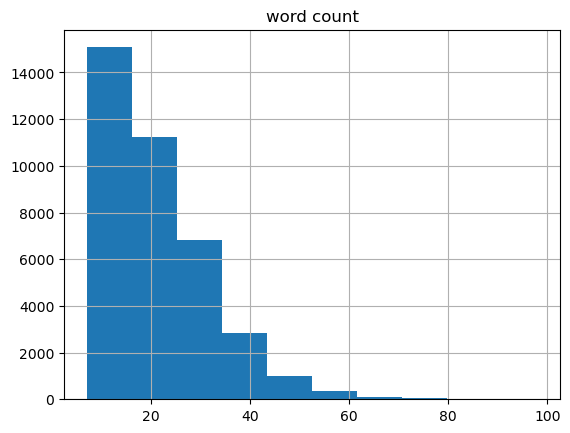

In [107]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
df_report.hist(column = 'word count')

In [127]:
df_report.drop_duplicates(subset = ['sentence'], inplace = True)

In [117]:
df_report.to_csv(fname_out, index = False)

In [115]:
df_report.isnull().sum()

doc_type      0
company       0
sentence      0
word count    0
dtype: int64